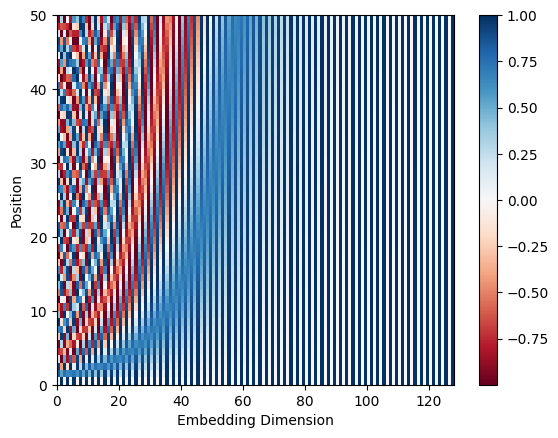

In [10]:
# 7.1 위치 인코딩
import math
import torch
from torch import nn
from matplotlib import pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [11]:
from pathlib import Path
src_path = Path(r"C:\Euron\Week12\train.de\train.de")
tgt_path = Path(r"C:\Euron\Week12\train.en\train.en")
src_val_path = Path(r"C:\Euron\Week12\val.de\val.de")
tgt_val_path = Path(r"C:\Euron\Week12\val.en\val.en")

In [12]:
#7.2 데이터세트 다운로드 및 전처리
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}

print("Token Transform:")
print(token_transform)

def read_lang_pair(src_file, tgt_file):
    with open(src_file, encoding="utf-8") as f_src, open(tgt_file, encoding="utf-8") as f_tgt:
        for src_line, tgt_line in zip(f_src, f_tgt):
            yield src_line.strip(), tgt_line.strip()

def yield_tokens(data_iter, language):
    lang_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for pair in data_iter:
        yield token_transform[language](pair[lang_index[language]])

train_pairs = list(read_lang_pair(src_path, tgt_path))

vocab_transform = {}
for lang in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab = build_vocab_from_iterator(
        yield_tokens(train_pairs, lang),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )
    vocab.set_default_index(UNK_IDX)
    vocab_transform[lang] = vocab

print("Vocab Transform:")
print(vocab_transform)

Token Transform:
{'de': functools.partial(<function _spacy_tokenize at 0x00000272631930A0>, spacy=<spacy.lang.de.German object at 0x000002727FA299F0>), 'en': functools.partial(<function _spacy_tokenize at 0x00000272631930A0>, spacy=<spacy.lang.en.English object at 0x000002720CE83400>)}
Vocab Transform:
{'de': Vocab(), 'en': Vocab()}


In [13]:
# 7.3 트랜스포머 모델 구성
import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

In [14]:
# 7.4 트랜스포머 모델 구조
from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

c:\Users\Somang\anaconda3\envs\euron\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


src_tok_emb
└ embedding
tgt_tok_emb
└ embedding
positional_encoding
└ dropout
transformer
└ encoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  └ norm
└ decoder
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  └ norm
generator


In [16]:
text_transform = {
    "de": sequential_transforms(token_transform["de"], vocab_transform["de"], input_transform),
    "en": sequential_transforms(token_transform["en"], vocab_transform["en"], input_transform),
}

In [17]:
# 7.5 배치 데이터 생성
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import torch

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def input_transform(token_ids):
    return torch.cat(
        (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
    )

def collator(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform["de"](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform["en"](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

class CustomTranslationDataset(Dataset):
    def __init__(self, src_file, tgt_file):
        with open(src_file, encoding="utf-8") as f_src, open(tgt_file, encoding="utf-8") as f_tgt:
            self.src_lines = [line.strip() for line in f_src]
            self.tgt_lines = [line.strip() for line in f_tgt]

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        return self.src_lines[idx], self.tgt_lines[idx]

data_iter = CustomTranslationDataset(src_val_path, tgt_val_path)
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

(source, target):
('Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen', 'A group of men are loading cotton onto a truck')
source_batch: torch.Size([35, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  14,    5,    5,  ...,    5,   21,    5],
        [  38,   12,   35,  ...,   12, 1750,   69],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
target_batch: torch.Size([30, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   6,    6,    6,  ...,  250,   19,    6],
        [  39,   12,   35,  ...,   12, 3254,   61],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [18]:
#7.6 어텐션 마스크 생성
def generate_square_subsequent_mask(s):
    mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)

print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask.shape)
print(target_padding_mask)

source_mask: torch.Size([35, 35])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
target_mask: torch.Size([29, 29])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
   

In [19]:
# 7.7 모델 학습 및 평가
def run(model, optimizer, criterion, split):
    model.train() if split == "train" else model.eval()

    if split == "train":
        data_iter = CustomTranslationDataset(src_path, tgt_path)
    elif split == "valid":
        data_iter = CustomTranslationDataset(src_val_path, tgt_val_path)

    dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            trg=target_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_output.reshape(-1))
        if split == "train":
            loss.backward()
            optimizer.step()
        losses += loss.item()

    return losses / len(list(dataloader))

for epoch in range(5):
    train_loss = run(model, optimizer, criterion, "train")
    val_loss = run(model, optimizer, criterion, "valid")
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

c:\Users\Somang\anaconda3\envs\euron\lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 4.656, Val loss: 3.951
Epoch: 2, Train loss: 3.684, Val loss: 3.559
Epoch: 3, Train loss: 3.384, Val loss: 3.476
Epoch: 4, Train loss: 3.230, Val loss: 3.449
Epoch: 5, Train loss: 3.093, Val loss: 3.436


In [20]:
# 7.8 트랜스포머 모델 번역 결과
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        target_mask = generate_square_subsequent_mask(ys.size(0))
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys

def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1]
    return " ".join(output)

output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebäude .")
print(output_oov)
print(output)

A group of people are standing outside of a building .
A group of people are standing on a bench .


In [22]:
# 7.9 문장 생성을 위한 GPT-2 모델의 구조
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path="gpt2")

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  63%|######3   | 346M/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer
└ wte
└ wpe
└ drop
└ h
│  └ 0
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 1
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 2
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 3
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 4
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 5
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 6
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 7
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 8
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 9
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 10
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 11
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
└ ln_f
lm_head


In [1]:
# 7.10 GPT-2를 이용한 문장 생성
from transformers import pipeline

generator = pipeline(task="text-generation", model="gpt2")
outputs = generator(
    text_inputs="Machine learning is",
    max_length=20,
    num_return_sequences=3,
    pad_token_id=generator.tokenizer.eos_token_id
)
print(outputs)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\Somang\anaconda3\envs\euron\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Somang\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': 'Machine learning is the same thing as the traditional computer-assisted learning, where the user can pick up'}, {'generated_text': 'Machine learning is taking off and a handful of firms are now embracing open source platforms.\n\nA'}, {'generated_text': "Machine learning is a very expensive undertaking, so that I'm not at a loss to explain it,"}]


In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import torch

# Load data
dataset = load_dataset("glue", "cola")
train_data = dataset["train"]
valid_data = dataset["validation"]
test_data = dataset["test"]

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Device
epochs = 3
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# Collator
def collator(batch, tokenizer, device):
    texts = [item["sentence"] for item in batch]
    labels = [item["label"] for item in batch]

    tokenized = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(labels, dtype=torch.long).to(device)

    return input_ids, attention_mask, labels

# DataLoaders
train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: collator(x, tokenizer, device)
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batch_size,
    collate_fn=lambda x: collator(x, tokenizer, device)
)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    collate_fn=lambda x: collator(x, tokenizer, device)
)

print("Train Dataset Length :", len(train_data))
print("Valid Dataset Length :", len(valid_data))
print("Test Dataset Length :", len(test_data))

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

c:\Users\Somang\anaconda3\envs\euron\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Somang\.cache\huggingface\hub\datasets--glue. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Train Dataset Length : 8551
Valid Dataset Length : 1043
Test Dataset Length : 1063


In [6]:
# 7.12 GPT-2 모델 설정
from torch import optim
from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
optimizer = optim.Adam(model.parameters(), lr=5e-5)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os

os.makedirs("../models", exist_ok=True)

In [13]:
# 7.13 GPT-2 모델 학습 및 검증
import numpy as np
from torch import nn

def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        
        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)
            
            val_loss += loss.item()
            val_accuracy += accuracy
    
    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy

best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/GPT2ForSequenceClassification.pt")
        print("Saved the model weights")

Epoch 1: Train Loss: 0.5578 Val Loss: 0.5431 Val Accuracy 0.7232
Saved the model weights
Epoch 2: Train Loss: 0.4380 Val Loss: 0.5576 Val Accuracy 0.7456
Epoch 3: Train Loss: 0.3144 Val Loss: 0.6217 Val Accuracy 0.7418


In [11]:
# 7.14 모델 평가
model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
model.load_state_dict(torch.load("../models/GPT2ForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
#print(f"Test Loss : {test_loss:.4f}")
#print(f"Test Accuracy : {test_accuracy:.4f}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'test_dataloader' is not defined